# Семестр 2. Задание 6. Метод простых итераций решения СЛАУ 

In [1]:
import numpy as np
from numba import cuda, types

## Генерация матрицы коэффициентов СЛАУ, имеющей единственное решение

In [2]:
4.28416074 / 18.73253158

0.22870164247175395

In [3]:
row = np.random.uniform(-10, 10, 3)            
abs_sum = np.sum(np.abs(row)) - np.abs(row[0])
row[0] = (abs_sum + 5.0) * np.random.choice([-1, 1])
a = np.delete(row, 0)
temp = np.sum(np.abs(a / row[0]))
print(row)
print(a)
print(temp)

[14.74088425 -6.69924012  3.04164413]
[-6.69924012  3.04164413]
0.660807322417771


In [4]:
def matrix_gen(n):
    arr = []
    for i in range(n):
        condition = 1
        while condition >= 1:
            row = np.random.uniform(-10, 10, n)            
            abs_sum = np.sum(np.abs(row)) - np.abs(row[i])
            row[i] = (abs_sum + 5.0) * np.random.choice([-1, 1])
            a = np.delete(row, i)
            condition = np.sum(np.abs(a / row[i]))
        arr.append(row)
    return np.array(arr, dtype=np.float32)

In [5]:
np.random.seed(42)
N = 3
A = matrix_gen(N)
B = np.random.uniform(-10, 10, N).astype(np.float32)
A, B

(array([[-18.654165 ,   9.014286 ,   4.6398787],
        [  1.9370031, -14.937505 ,  -8.000502 ],
        [  7.323523 ,   2.0223002,  14.345823 ]], dtype=float32),
 array([-8.871768 ,  4.4399753,  8.771054 ], dtype=float32))

## Последовательное решение

In [6]:
def simple_iterations(A, B, N):
    xs = np.ones(N)
    new_xs = np.zeros(N)
    a = A.copy()
    np.fill_diagonal(a, 0)
    for i in range(100):
        for k in range(N):
            new_xs[k] = (B[k] - np.sum(a[k]*xs)) / A[k][k]
        xs = new_xs
    return xs

In [7]:
simple_iterations(A, B, N)

array([ 0.34869132, -0.5236855 ,  0.50721764])

In [8]:
np.linalg.solve(A,B) # проверка решения

array([ 0.3486913 , -0.5236855 ,  0.50721765], dtype=float32)

## Параллельное решение

In [9]:
@cuda.jit
def iter_kernel(A, B, a, xs, new_xs, N):
    idx = cuda.grid(1)
    if idx < N:
        summ = 0
        for i in range(N):
           summ += a[idx*N+i]*xs[i]
        new_xs[idx] = (B[idx] - summ) / A[idx*N+idx]
        cuda.syncthreads()    

In [10]:
TBP = 1024
BPG = N // TBP + 1

def simple_iterations_gpu(A, B, N):
    A_device = cuda.to_device(A.flatten())
    B_device = cuda.to_device(B)
    xs = np.ones(N, dtype=np.float32)
    xs_device = cuda.to_device(xs)
    new_xs = np.zeros(N, dtype=np.float32)
    new_xs_device = cuda.to_device(new_xs)
    a = A.copy()
    np.fill_diagonal(a, 0)
    a_device = cuda.to_device(a.flatten())
    for i in range(100):
        iter_kernel[BPG, TBP](A_device, B_device, a_device, xs_device, new_xs_device, N)
        xs_device = new_xs_device
    xs_device.copy_to_host(xs)
    return xs

In [11]:
simple_iterations_gpu(A, B, N)

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.3486913 , -0.5236855 ,  0.50721765], dtype=float32)

In [12]:
np.linalg.solve(A,B) # проверка решения

array([ 0.3486913 , -0.5236855 ,  0.50721765], dtype=float32)

## Сравнение скорости последовательного и параллельного алгоритма на матрицах коэффицентов разного размера и 100 итерациях

### Последовательный N = 100

In [13]:
np.random.seed(42)
N = 100
A = matrix_gen(N)
B = np.random.uniform(-10, 10, N).astype(np.float32)

In [14]:
%%timeit
simple_iterations(A, B, N)

59 ms ± 469 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Параллельный N = 100

In [15]:
%%timeit
simple_iterations_gpu(A, B, N)

11.1 ms ± 270 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Последовательный N = 1000

In [16]:
np.random.seed(42)
N = 1000
A = matrix_gen(N)
B = np.random.uniform(-10, 10, N).astype(np.float32)

In [17]:
%%timeit
simple_iterations(A, B, N)

857 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Параллельный N = 1000

In [18]:
%%timeit
simple_iterations_gpu(A, B, N)

181 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Последовательный N = 10 000

In [19]:
np.random.seed(42)
N = 10000
A = matrix_gen(N)
B = np.random.uniform(-10, 10, N).astype(np.float32)

In [20]:
%%timeit
simple_iterations(A, B, N)

19.4 s ± 60.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Параллельный N = 10 000

In [21]:
%%timeit
simple_iterations_gpu(A, B, N)

2.86 s ± 61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Сравнение результатов по времени

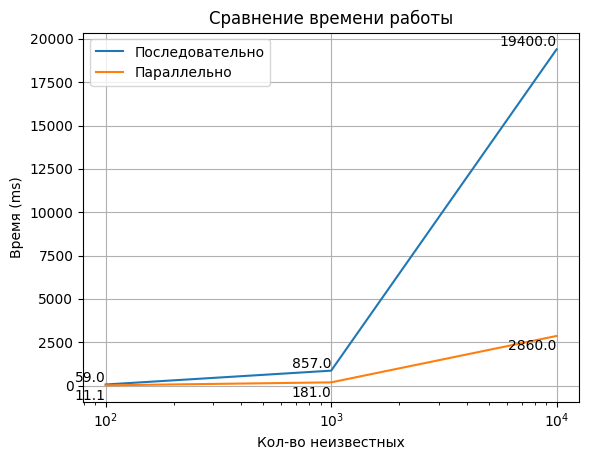

In [4]:
import matplotlib.pyplot as plt

ns = [100, 1000, 10000]
s_times = [59., 857., 19400.]
p_times = [11.1, 181., 2860.]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
for x, y in zip(ns, s_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')

for x, y in zip(ns, p_times):
    plt.text(x, y-1000, f'{y:.1f}', ha='right', va='bottom')
plt.title("Сравнение времени работы")
plt.xlabel("Кол-во неизвестных")
plt.ylabel("Время (ms)")
plt.xscale('log')
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
plt.show()